# Visualisation of median rental prices by postcode

In [1]:
# Import necessary libraries
import folium
import geopandas as gpd
import pandas as pd

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Create geoJSON file of postcode and geometry coordinates 
sf = gpd.read_file("../data/raw/external/POA_2021_AUST_GDA2020/POA_2021_AUST_GDA2020.shp")
postcodes = pd.read_csv("../data/raw/external/postcode.csv", names = ["POA_CODE21", "Name", "Area"])
postcodes["POA_CODE21"] = postcodes["POA_CODE21"].astype(int)

# Convert the geometry shape to to latitude and longitude
# TAKEN FROM TUTE 2 NOTEBOOK
sf["geometry"] = sf["geometry"].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
sf = sf[sf["POA_CODE21"].between("3000", "4000")]
sf["POA_CODE21"] = sf["POA_CODE21"].astype(int)

gdf = gpd.GeoDataFrame(
    pd.merge(postcodes, sf, on="POA_CODE21", how="inner")
)

geoJSON = gdf[["POA_CODE21", "geometry"]].drop_duplicates("POA_CODE21").to_json()

In [3]:
# (y, x) since we want (lat, long)
gdf["centroid"] = gdf["geometry"].apply(lambda x: (x.centroid.y, x.centroid.x))
gdf[["Name", "POA_CODE21", "centroid"]].head()

# input necessary dataframe and calculate median for each postcode 
property_df = pd.read_csv("../data/curated/categorised_distances.csv")
df = pd.DataFrame(property_df.groupby(["Postcode"])["Cost"].median()).reset_index()
df.rename({"Postcode": "POA_CODE21"})

m = folium.Map(location=[-37.8136, 144.9631], tiles="Stamen Terrain", zoom_start=10)

c = folium.Choropleth(
            geo_data=geoJSON, # geoJSON 
            name="choropleth", # name of plot
            data=df, # data source
            columns=["Postcode", "Cost"], # the columns required
            key_on="properties.POA_CODE21", # this is from the geoJSON's properties
            fill_color="YlOrRd", # color scheme
            nan_fill_color="grey",
            legend_name= "Median Rental Prices"
        )

c.add_to(m)
m.save(f"../plots/victoria_rental_prices_heatmap")

For better comparisons, outliers with median rental prices of greater than $XX were omitted. This gave a better visualisation of the rental distribution in more suburbs

In [4]:
df.sort_values(by = ["Cost"], ascending = False)

,Postcode,Cost
380,3929,2650.000
279,3621,1825.000
392,3944,1800.000
272,3564,1495.165
320,3759,1200.000
...,...,...
211,3318,230.000
259,3490,220.000
235,3409,200.000
333,3799,200.000


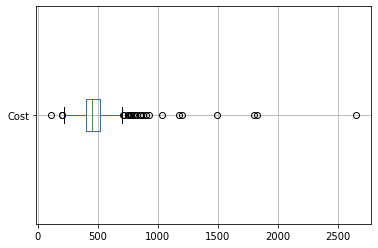

In [5]:
medianprices = df.boxplot(column = ["Cost"], vert = False)

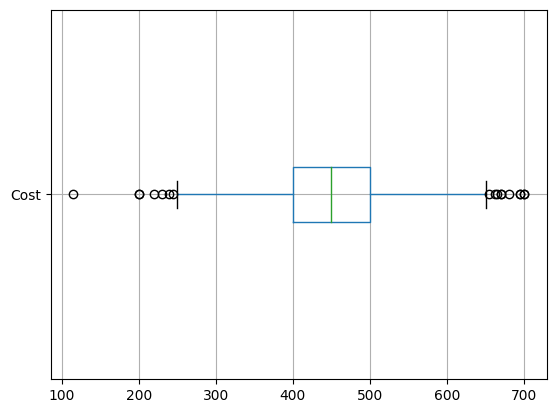

In [6]:
df_adjusted = df[(df["Cost"] <= 700)]
medianprices = df_adjusted.boxplot(column = ["Cost"], vert = False)

In [7]:
m = folium.Map(location=[-37.8136, 144.9631], tiles="Stamen Terrain", zoom_start=10)

c = folium.Choropleth(
            geo_data=geoJSON, # geoJSON 
            name="choropleth", # name of plot
            data=df_adjusted, # data source
            columns=["Postcode", "Cost"], # the columns required
            key_on="properties.POA_CODE21", # this is from the geoJSON's properties
            fill_color="YlOrRd", # color scheme
            nan_fill_color="grey",
            legend_name= "Median Rental Prices"
        )

c.add_to(m)
m.save(f"../plots/victoria_rental_prices_heatmap_reduced")